<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/Ariadne%2B_superpixel%2Bgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lar-unibo/ariadne_plus.git
%cd ariadne_plus

Cloning into 'ariadne_plus'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 77 (delta 7), reused 11 (delta 1), pack-reused 55 (from 1)
Receiving objects: 100% (77/77), 46.69 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/ariadne_plus


In [2]:
!pip install pytorch-lightning==1.4.2
!pip install segmentation-models-pytorch
!pip install timm
!pip install albumentations
!pip install opencv-python
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.6/916.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 48.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
%pwd

'/content/ariadne_plus'

In [4]:
%%writefile requirements.txt
torch
torchvision
torchaudio
opencv-python
scikit-image
matplotlib
tqdm
pyyaml

Writing requirements.txt


In [5]:
!pip install -r requirements.txt

In [6]:
!pip install torchmetrics==0.11.4 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 7.6 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!mkdir -p scripts/checkpoints
!cp "/content/drive/MyDrive/Colab Notebooks/deeplab.pth" scripts/checkpoints/model_deeplab.pth

In [9]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/backbone/resnet.py

In [10]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/_deeplab.py

In [11]:
!sed -i 's/from torchvision.models.utils import/from torch.hub import/' scripts/core/backbone/mobilenetv2.py

In [12]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from scripts.core import deeplabv3plus_resnet101, convert_to_separable_conv
from scripts.utils.dataset import BasicDataset

# Load model
model = deeplabv3plus_resnet101(num_classes=1, output_stride=16)
convert_to_separable_conv(model.classifier)
checkpoint = torch.load("scripts/checkpoints/model_deeplab.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 53.7MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
from google.colab import files
uploaded = files.upload()

Saving simple_0.jpg to simple_0.jpg


In [14]:
img = cv2.imread("simple_0.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_pre = torch.from_numpy(BasicDataset.pre_process(img_rgb)).unsqueeze(0).float()

with torch.no_grad():
    output = model(img_pre)
    mask = torch.sigmoid(output).squeeze().numpy()

mask_bin = (mask > 0.5).astype(np.uint8) * 255

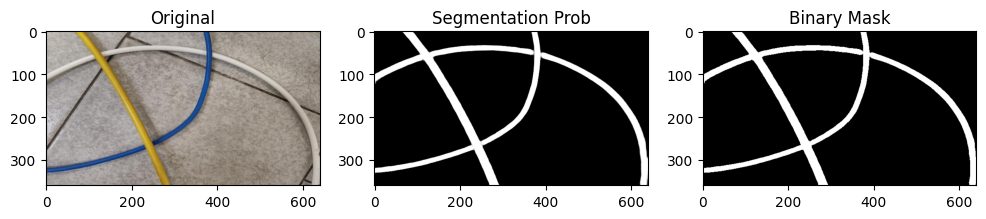

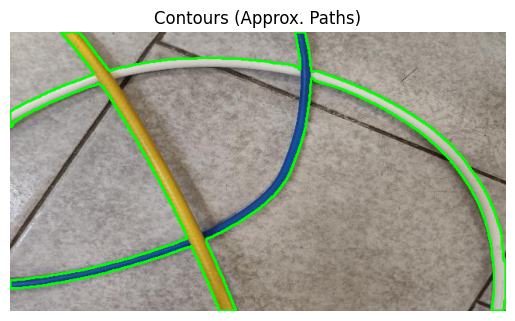

In [15]:
# Show segmentation result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmentation Prob")

plt.subplot(1, 3, 3)
plt.imshow(mask_bin, cmap='gray')
plt.title("Binary Mask")
plt.show()

# Contour visualization
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)

plt.imshow(contour_img)
plt.title("Contours (Approx. Paths)")
plt.axis('off')
plt.show()


In [26]:
cv2.imwrite("binary_mask.png", mask_bin)



True

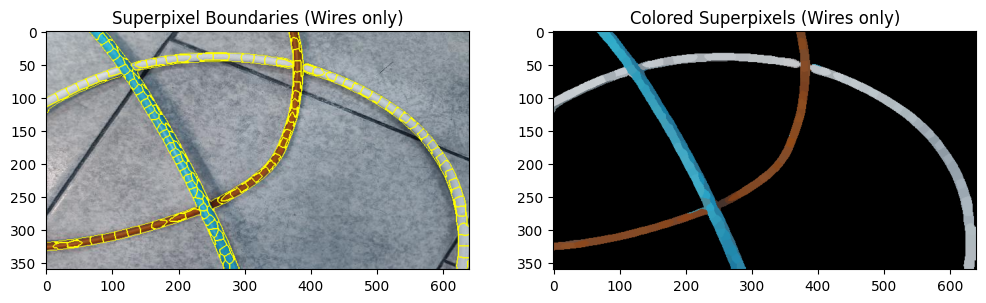

In [27]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt

# 1. Make sure mask_bin is binary and img is RGB
masked_img = img.copy()
masked_img[mask_bin == 0] = 0  # Mask background to black

# 2. Apply superpixel segmentation only on masked wires
segments = slic(masked_img, n_segments=200, compactness=10, sigma=1, mask=mask_bin.astype(bool))

# 3. Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(mark_boundaries(img, segments))
ax[0].set_title("Superpixel Boundaries (Wires only)")

colored_segments = label2rgb(segments, img, kind='avg')
ax[1].imshow(colored_segments)
ax[1].set_title("Colored Superpixels (Wires only)")

plt.show()


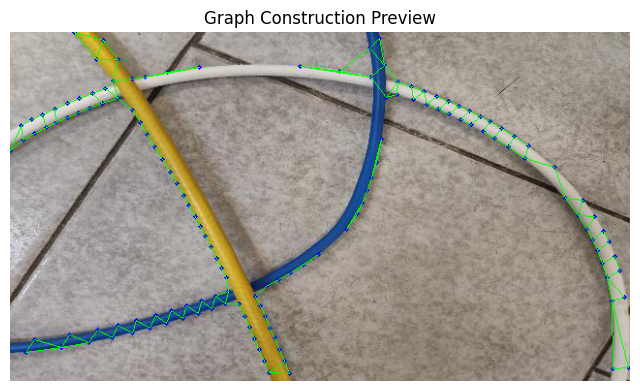

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Find contours
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 2: Sample points along contours
sampled_points = []
for contour in contours:
    for i in range(0, len(contour), 10):  # sample every 10th point
        pt = tuple(contour[i][0])  # (x, y)
        sampled_points.append(pt)

# Step 3: Create graph
G = nx.Graph()
for i, pt in enumerate(sampled_points):
    G.add_node(i, pos=pt)

# Step 4: Connect nearby points (you can use kNN-style connection)
from scipy.spatial import KDTree
tree = KDTree(sampled_points)
for i, pt in enumerate(sampled_points):
    dists, idxs = tree.query(pt, k=3)  # connect to 2 nearest neighbors
    for j in idxs[1:]:  # skip self
        G.add_edge(i, j)

# Step 5: Draw on image
img_graph = img.copy()
for pt in sampled_points:
    cv2.circle(img_graph, pt, 2, (255, 0, 0), -1)  # blue dots

for i, j in G.edges():
    pt1 = G.nodes[i]['pos']
    pt2 = G.nodes[j]['pos']
    cv2.line(img_graph, pt1, pt2, (0, 255, 0), 1)  # green edges

# Display
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_graph, cv2.COLOR_BGR2RGB))
plt.title("Graph Construction Preview")
plt.axis('off')
plt.show()


In [18]:
!pip install arrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.9 MB/s eta 0:00:00


In [20]:
!pip install opencv-contrib-python